Importing necessary libraries


In [ ]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import random
from tensorflow.keras import layers

Connecting To Google Drive

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting up the paths and testing

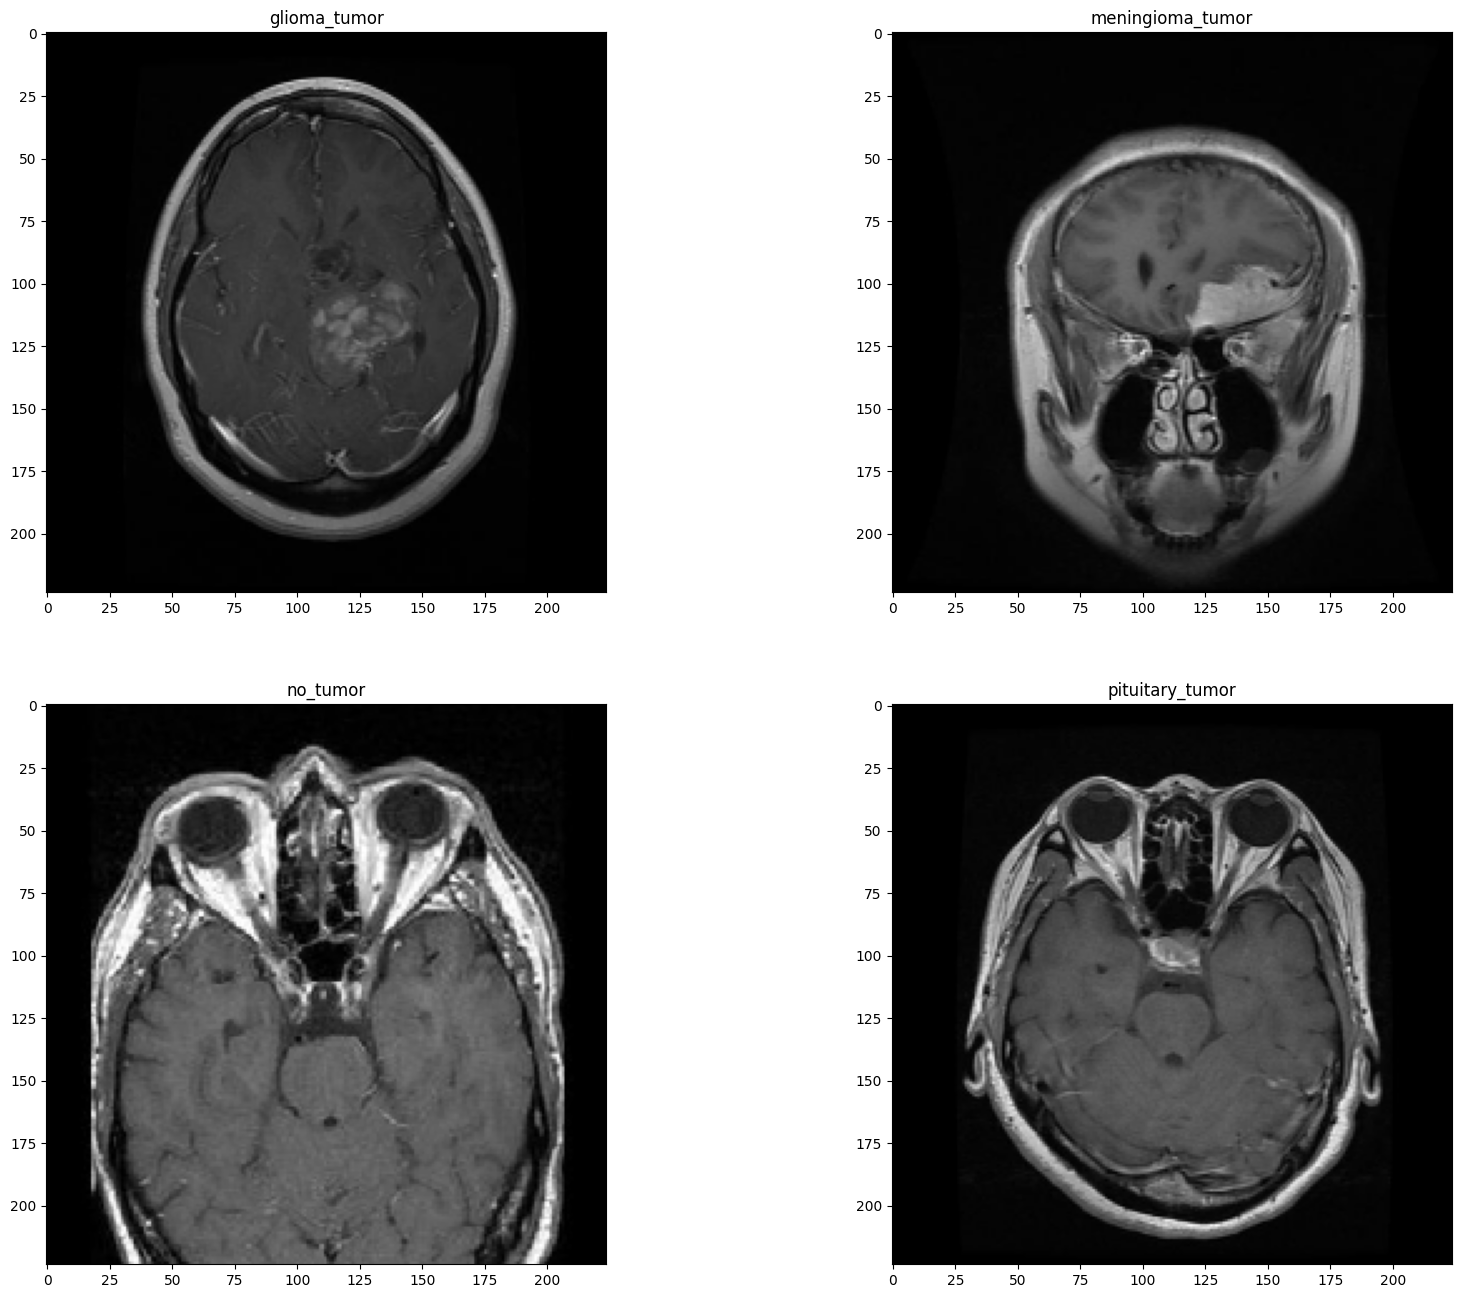

In [ ]:
# Sample Image Paths
data_dir = '/content/drive/MyDrive/NNDLDataSets/BrainTumorDetection_DS/Training'

categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
plt.figure(figsize=(20, 16))

images_path = ['/glioma_tumor/gg (1).jpg', '/meningioma_tumor/m (10).jpg', '/no_tumor/1.jpg', '/pituitary_tumor/p (1).jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])

Image Preprocessing

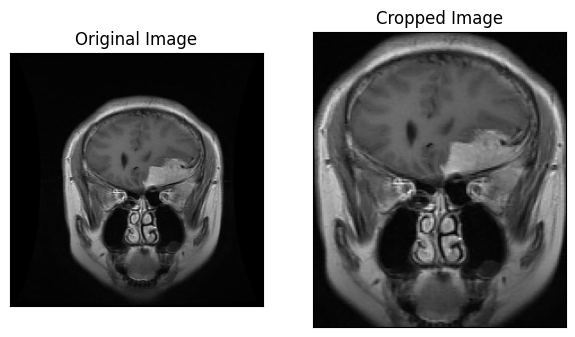

In [ ]:
# Image Cropping Function
def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)# converts the color space of an image 
    gray = cv2.GaussianBlur(gray, (3, 3), 0)# removing gaussian noise from an image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]# converts all pixels above a certain grey scale value either white or black
    thresh = cv2.erode(thresh, None, iterations=2)# perform Erosion on the images
    thresh = cv2.dilate(thresh, None, iterations=2)# adds pixels to the boundaries of the objects in an image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)# turns all pixels above a certain grey scale value either white or black
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # setting uo the 4 corners - top bottom right left
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

# apply cropping
img = cv2.imread('/content/drive/MyDrive/Brain Tumor Detection/MRI Datasets/Training/meningioma_tumor/m (10).jpg')
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cropped_img = crop_img(img)

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([]), plt.yticks([]), plt.title('Original Image')
plt.subplot(142)
plt.imshow(cropped_img)
plt.xticks([]), plt.yticks([]), plt.title('Cropped Image')
plt.show()

Preparing the data

100%|██████████| 74/74 [00:00<00:00, 114.45it/s]


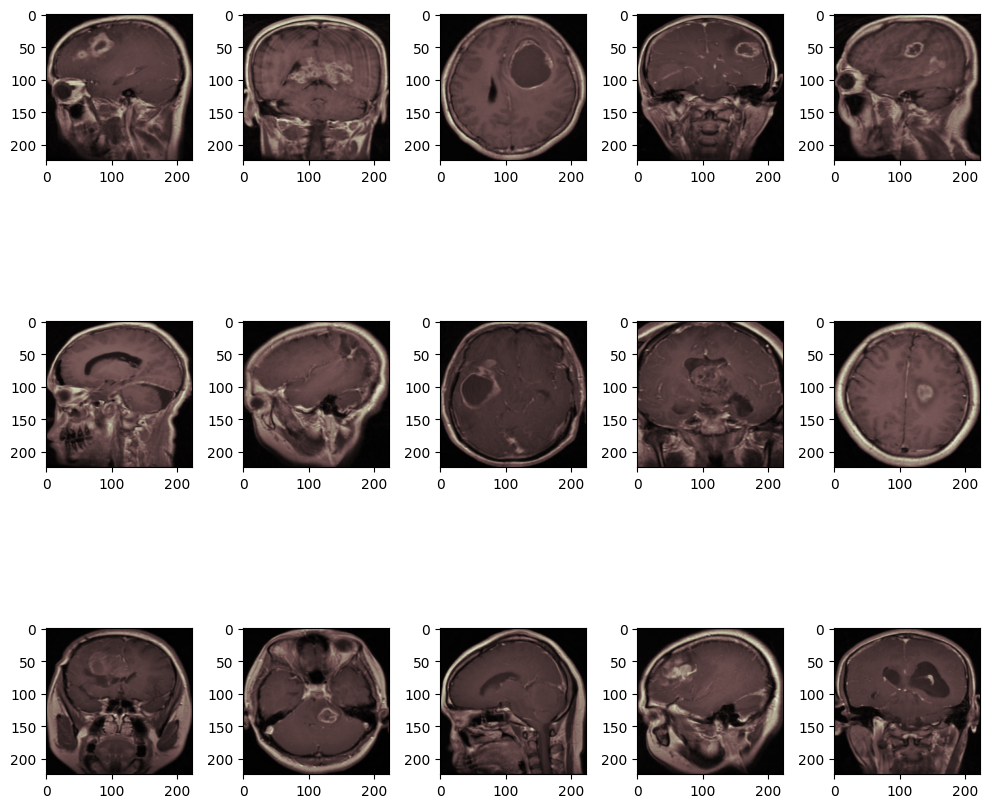

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

x_train = []
y_train  = []
x_test = []
y_test = []

image_size = 224

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Brain Tumor Detection/MRI Datasets/cropped/Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/content/drive/MyDrive/Brain Tumor Detection/MRI Datasets/cropped/Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Visualizing images
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

Setting up the dataset for Training , Testing 

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

# Splitting the whole dataset in two parts : for training -> 80% and testing -> 20% of the dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Image Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2)

datagen.fit(x_train)

Preparing the CNN model

In [9]:
# Custom CNN Model

IMG_SIZE = (224, 224, 3)  # Input image size

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SIZE),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the 3D output to 1D
    Flatten(),

    # Fully Connected Layer 1
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer (softmax for multi-class classification)
    Dense(4, activation='softmax')  # 4 classes for classification
])

# Compile the model
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,859,268 (98.65 MB)

 Trainable params: 25,858,564 (98.64 MB)

 Non-trainable params: 704 (2.75 KB)

Using callback function

In [10]:
# Callbacks
callbacks = [
    ModelCheckpoint('.mdl_wts.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=1e-10),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

Applying callback to the model

In [11]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(x_val, y_val), epochs=15, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.3576 - loss: 3.1114
Epoch 1: val_loss improved from inf to 2.23869, saving model to .mdl_wts.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3578 - loss: 3.0853 - val_accuracy: 0.2865 - val_loss: 2.2387 - learning_rate: 1.0000e-04
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.3617 - loss: 1.3298
Epoch 2: val_loss did not improve from 2.23869
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 805ms/step - accuracy: 0.3623 - loss: 1.3292 - val_accuracy: 0.2865 - val_loss: 3.8038 - learning_rate: 1.0000e-04
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.3824 - loss: 1.2900
Epoch 3: val_loss did not improve from 2.23869

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 796ms/step - accuracy: 0.3824 - loss: 1.2895 - val_accuracy: 0.2917 - val_loss: 4.5032 - learning_rate: 1.0000e-04
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - ac

Loss and Accuracy Graph 

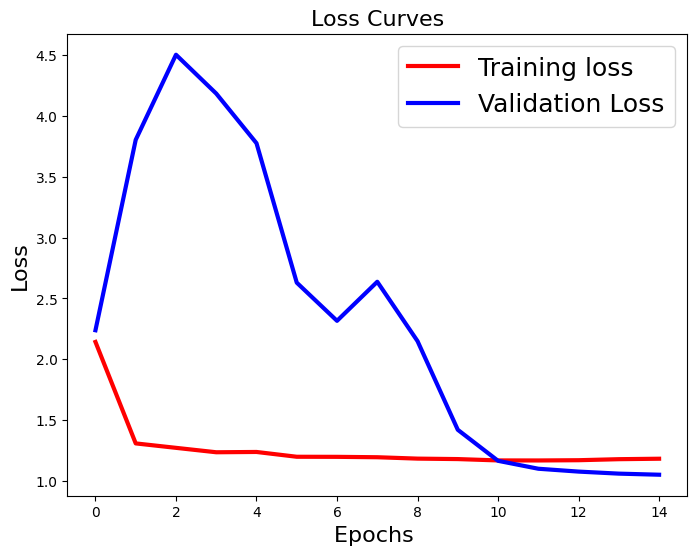

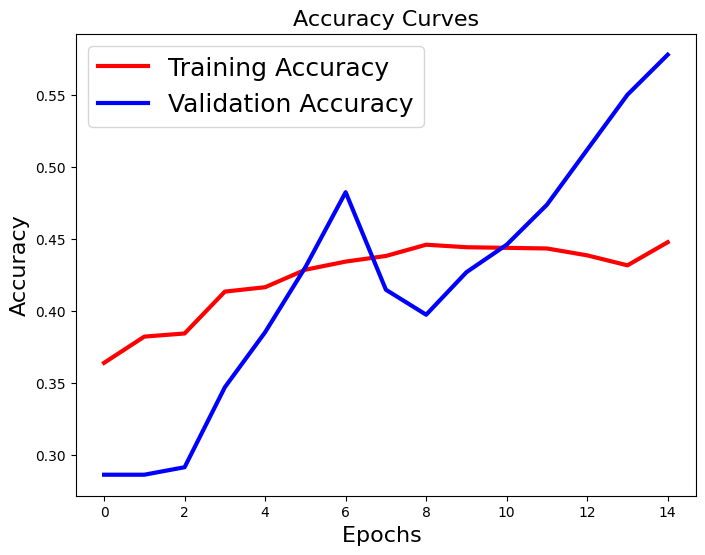

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [13]:
# Evaluation on Test Set
loss, acc = model.evaluate(x_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.3333 - loss: 3.4404


Classification Report

In [ ]:
predicted_classes = np.argmax(model.predict(x_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.27      0.25      0.26       100
meningioma_tumor       0.41      0.60      0.49       115
        no_tumor       0.20      0.16      0.18       105
 pituitary_tumor       0.41      0.27      0.33        74

        accuracy                           0.33       394
       macro avg       0.32      0.32      0.31       394
    weighted avg       0.32      0.33      0.32       394



Confusion Matrix

In [15]:
# Confusion Matrix
pred_Y = model.predict(x_test, batch_size=8, verbose=True)
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_Y, axis=1))

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


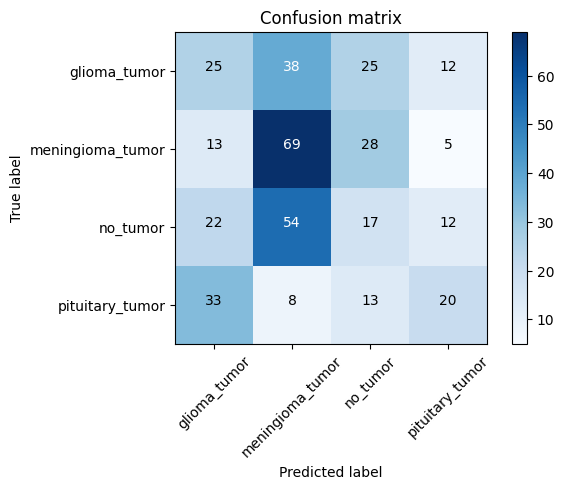

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot Confusion Matrix
plot_confusion_matrix(confusion_mtx, classes=labels)

Implementing roc_curve and auc_curve

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


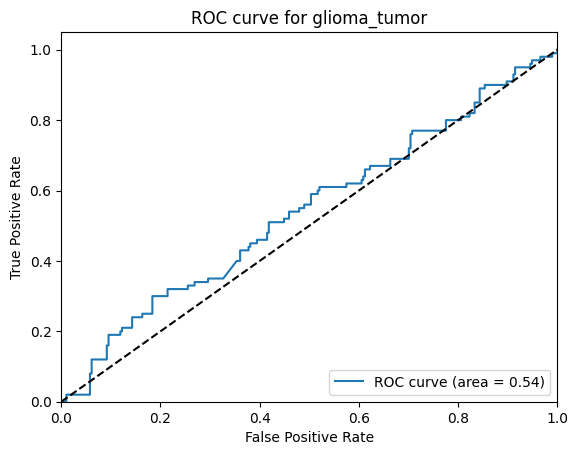

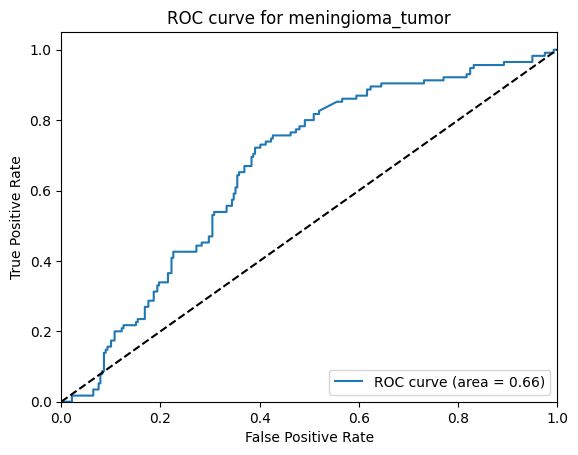

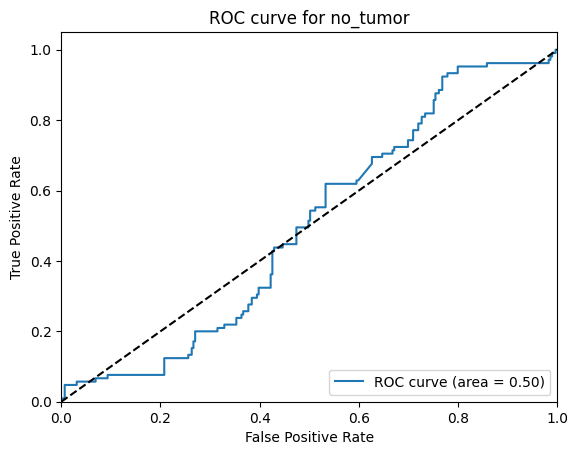

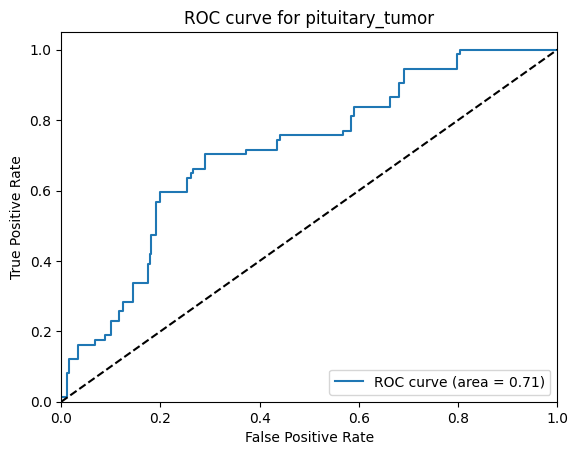

In [17]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
y_test = np.array(y_test)
n_classes = 4

pred_Y = model.predict(x_test, batch_size=16, verbose=True)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {labels[i]}')
    plt.legend(loc="lower right")
    plt.show()

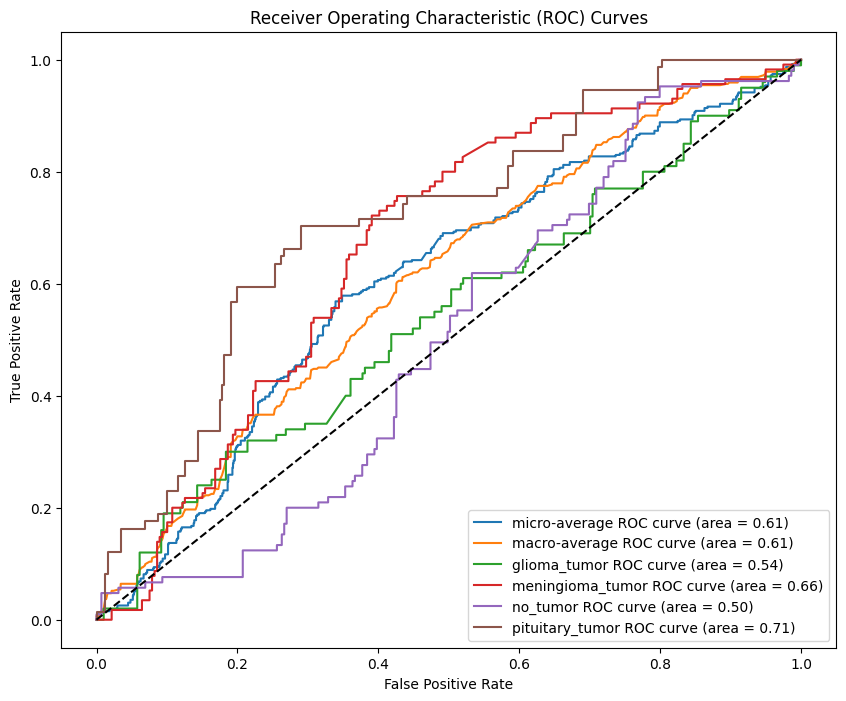

In [18]:
# Plot all ROC Curves
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = %0.2f)' % roc_auc["macro"])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()